In [11]:
from pathlib import Path
import numpy as np
import pandas as pd
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt

PROJECT_DIR = Path("..").resolve()  # ajuste se seu notebook não estiver em notebooks/
DATA_PATH = PROJECT_DIR / "data" / "gold" / "train_features.parquet"

# Escolha qual modelo explicar:
MODEL_PATH = PROJECT_DIR / "models" / "random_forest_tuned.joblib"  # ou random_forest.joblib

In [12]:
model = joblib.load(MODEL_PATH)
df = pd.read_parquet(DATA_PATH)

print("Loaded df:", df.shape)
print("Model:", type(model))
print("Has feature_names_in_:", hasattr(model, "feature_names_in_"))

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.5.1 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loaded df: (1017209, 33)
Model: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
Has feature_names_in_: True


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.5.1 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [13]:
TARGET = "Sales"

df = df.copy()

# Se por acaso existir Date (datetime), cria Date_ts e remove Date
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df["Date_ts"] = df["Date"].astype("int64", errors="ignore")
    df = df.drop(columns=["Date"])

# X/y
y = df[TARGET].astype(float)
X = df.drop(columns=[TARGET])

# Se ainda restar alguma coluna object/categorical, faz one-hot
non_num = X.select_dtypes(exclude=["number"]).columns.tolist()
if non_num:
    X = pd.get_dummies(X, columns=non_num, drop_first=False)

# Tudo numérico
X = X.apply(pd.to_numeric, errors="coerce").fillna(0.0)

print("X shape:", X.shape)
print("Non-numeric left:", X.select_dtypes(exclude=["number"]).columns.tolist())

X shape: (1017209, 42)
Non-numeric left: ['PromoInterval_Feb,May,Aug,Nov', 'PromoInterval_Jan,Apr,Jul,Oct', 'PromoInterval_Mar,Jun,Sept,Dec', 'StateHoliday_a_False', 'StateHoliday_a_True', 'StateHoliday_b_False', 'StateHoliday_b_True', 'StateHoliday_c_False', 'StateHoliday_c_True', 'StoreType_b_False', 'StoreType_b_True', 'StoreType_c_False', 'StoreType_c_True', 'StoreType_d_False', 'StoreType_d_True', 'Assortment_b_False', 'Assortment_b_True', 'Assortment_c_False', 'Assortment_c_True']


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

train_cols = None
if hasattr(model, "feature_names_in_"):
    train_cols = list(model.feature_names_in_)

if train_cols is None:
    # fallback: usa as colunas atuais
    train_cols = list(X_train.columns)

# Reindex: adiciona as faltantes com 0, remove as extras, e mantém a ordem
X_train = X_train.reindex(columns=train_cols, fill_value=0.0)
X_test  = X_test.reindex(columns=train_cols, fill_value=0.0)

print("Aligned X_train:", X_train.shape)
print("Aligned X_test :", X_test.shape)

Aligned X_train: (813767, 34)
Aligned X_test : (203442, 34)


In [15]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE :", mae)
print("RMSE:", rmse)

MAE : 651.4763414373997
RMSE: 1229.281254554553


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Saved -> /Users/edonaire/Documents/governance-first-sales-prediction/reports/figures/permutation_importance_top20.png


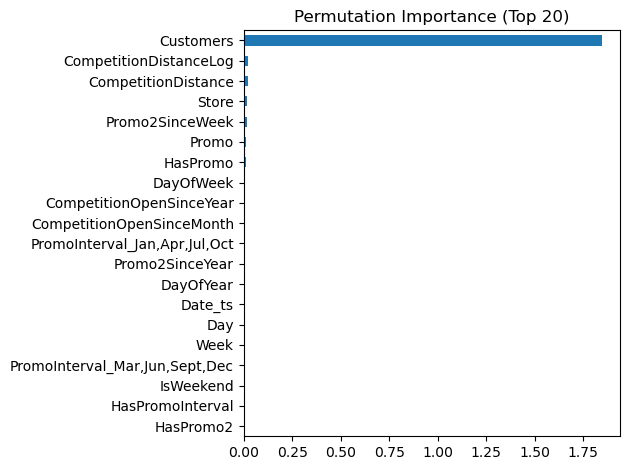

In [16]:
# Para rodar rápido (se quiser), amostra:
N = 50000
if len(X_test) > N:
    X_pi = X_test.sample(N, random_state=42)
    y_pi = y_test.loc[X_pi.index]
else:
    X_pi, y_pi = X_test, y_test

result = permutation_importance(
    model, X_pi, y_pi,
    n_repeats=5,
    random_state=42,
    n_jobs=-1
)

importances = pd.Series(result.importances_mean, index=X_test.columns).sort_values(ascending=False)

top = importances.head(20)

plt.figure()
top.sort_values().plot(kind="barh")
plt.title("Permutation Importance (Top 20)")
plt.tight_layout()

OUT_DIR = PROJECT_DIR / "reports" / "figures"
OUT_DIR.mkdir(parents=True, exist_ok=True)
out_path = OUT_DIR / "permutation_importance_top20.png"
plt.savefig(out_path, dpi=150)
print("Saved ->", out_path.resolve())
plt.show()